# Homework 4: Cat and Dog Dataset
- 고양이와 강아지 사진을 CNN 모델을 활용해 분류해보자
- Image Data Generator 를 사용해 이미지의 수를 증강시켜 학습에 활용해보자
- 기본 신경망 모델에 batch normalization, max pooling, dropout 을 사용해보자

### 1. Load the Dataset

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import zipfile
import warnings
warnings.filterwarnings(action='ignore')
import keras
from keras.preprocessing import image
from IPython.display import Image 
from sklearn.model_selection import train_test_split

In [2]:
with zipfile.ZipFile('./dogs-vs-cats/train.zip', 'r') as z :
    z.extractall()

In [3]:
with zipfile.ZipFile('./dogs-vs-cats/test1.zip', 'r') as z :
    z.extractall()

### 2. Data Pre-processing

In [4]:
filenames = os.listdir("./train")
categories = []
for image in filenames :
    category = image.split('.')[0]
    if category == 'dog' :
        categories.append(1)
    else :    
        categories.append(0)
        
# 레이블이 강아지이면 1, 고양이이면 0 으로 카테고리를 부여한다.

In [5]:
train_df = pd.DataFrame({'filename' : filenames, 'category' : categories})
train_df.head(10)

,filename,category
0,dog.8011.jpg,1
1,cat.5077.jpg,0
2,dog.7322.jpg,1
3,cat.2718.jpg,0
4,cat.10151.jpg,0
5,cat.3406.jpg,0
6,dog.1753.jpg,1
7,cat.4369.jpg,0
8,cat.7660.jpg,0
9,dog.5535.jpg,1


In [6]:
train_df['category'].value_counts()
# 강아지, 고양이 사진이 각 12,500개씩 있음을 확인한다.

1    12500
0    12500
Name: category, dtype: int64

#### Show train images for sample

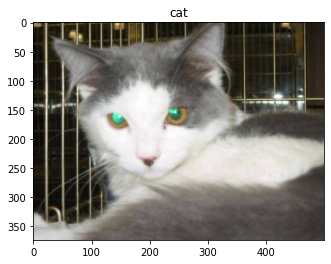

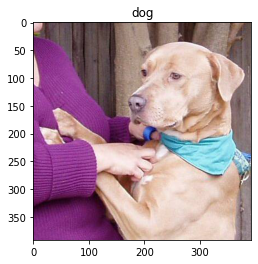

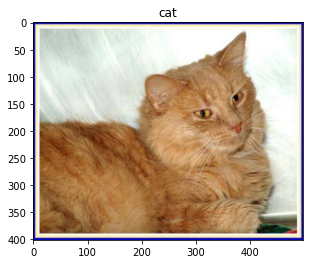

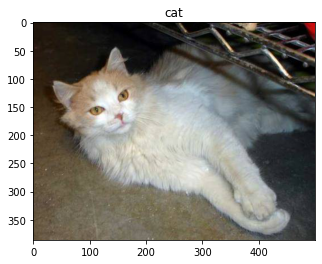

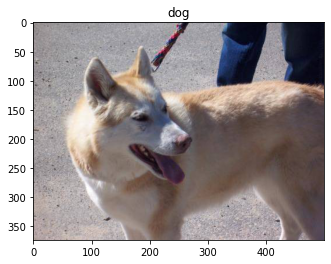

In [7]:
for i in range(5) :
    sample = filenames[i+5]
    image = keras.preprocessing.image.load_img('./train/' + sample)
    plt.imshow(image)
    plt.title('dog' if categories[i+5]==1 else 'cat') # 레이블: 강아지(1), 고양이(0)
    plt.show()

In [8]:
filenames = os.listdir("./test1")
categories = []
for image in filenames :
    category = image.split('.')[0]
    if category == 'dog' :
        categories.append(1)
    else :    
        categories.append(0)

In [9]:
test_df = pd.DataFrame({'filename' : filenames, 'category' : categories})
test_df.head(10)

,filename,category
0,9733.jpg,0
1,63.jpg,0
2,6400.jpg,0
3,823.jpg,0
4,4217.jpg,0
5,3578.jpg,0
6,10321.jpg,0
7,2666.jpg,0
8,5109.jpg,0
9,11981.jpg,0


In [11]:
# 이미지의 가로, 세로 길이와 사이즈, 흑백/컬러 여부 정하기
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNEL= 3

### 3. Image Data Generator
케라스에 내장된 라이브러리인 ImageDataGenerator 를 사용해 Data Augmentation 을 진행한다.

In [12]:
from keras.preprocessing.image import ImageDataGenerator

ImageDataGenerator 에서 class_mode = "categorical" 로 지정하기 위해 column category를 숫자에서 문자열으로 변경해준다.

In [13]:
train_df['category'] = train_df['category'].replace({0:'cat',1:"dog"})

In [14]:
train_df, val_df = train_test_split(train_df , test_size=0.2, random_state= 42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [15]:
path = "/Users/lifeofpy/ADL"

total_train = train_df.shape[0]
total_val = val_df.shape[0]
batch_size = 15

# 학습 데이터의 제너레이터 설정 
train_datagen=ImageDataGenerator(
        rotation_range=15,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.1, 
        height_shift_range=0.1)
        
train_generator=train_datagen.flow_from_dataframe(
    train_df, 
    path+"/train",
    x_col = "filename", 
    y_col = "category",
    target_size = IMAGE_SIZE,
    class_mode = "categorical",
    batch_size = batch_size )
    
val_datagen=ImageDataGenerator(rescale=1./255)

val_generator=val_datagen.flow_from_dataframe(
    val_df,
    path+"/train",
    x_col= "filename",
    y_col= "category",
    target_size = IMAGE_SIZE,
    class_mode = "categorical",
    batch_size = batch_size)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


Image Data Generator 사용 후 이미지가 잘 증강되었는지 확인하기 위해 샘플 데이터를 확인해본다.

In [16]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_df

,filename,category
0,dog.4684.jpg,dog


In [17]:
example_generator = train_datagen.flow_from_dataframe(
                    example_df,
                    path+"/train",
                    x_col = "filename",
                    y_col = "category",
                    target_size = IMAGE_SIZE,
                    class_mode = "categorical")

Found 1 validated image filenames belonging to 1 classes.


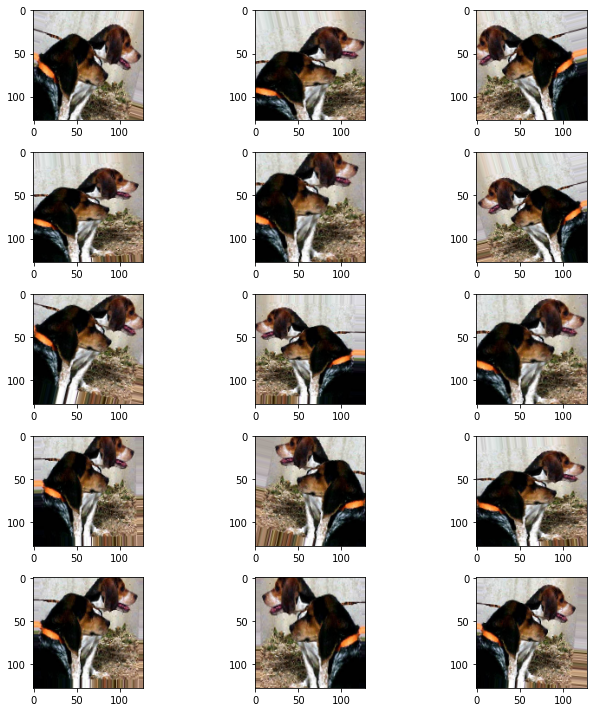

In [18]:
plt.figure(figsize=(10,10))
for i in range(0,15):
    plt.subplot(5,3,i+1)
    for xBatch, yBatch in example_generator:
        image = xBatch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

이미지가 잘 증강되었음을 확인할 수 있다.

## Experiments

In [19]:
from keras import models
from keras import layers
from keras.layers import *
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import optimizers 

### (1) Basic Neural Network Model + Batch Normalization + Max Pooling + Dropout
**Batch Normalization** 는 활성화 함수의 출력값을 정규분포로 만든다. 배치마다 정규화를 해서 hidden layer 의 중간에서 입력분포의 평균을 0, 분산을 1로 만들어준다.

**Max Pooling** 은 feature map 이 쌓여있는 스택을 입력으로 받기 때문에 window(일종의 time step)상에서 포함하고 있는 픽셀들 중 최댓값을 뽑아낼 수 있다.

**Dropout** 은 마지막 결과를 계산하기 위해 연산되는 몇몇 뉴런을 누락시켜 중간의 활성화 뉴런들을 동작하지 않게 해 남은 뉴런들로만 훈련을 해 오버피팅을 방지한다. 

- activation function: relu
- optimizer: Adam
- loss function: mean_squared_error
- batch size: 64
- epoch: 5
- **batch normalization**
- **max pooling**
- **dropout**

In [20]:
# Layer 1
model = Sequential()
model.add(Conv2D(32, (3,3), activation="relu", input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH , IMAGE_CHANNEL)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Layer 2
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Layer 3
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
          
# Fully Connected 
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2,activation="softmax"))

In [21]:
model.compile(optimizer='adam',
             loss='mean_squared_error',
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [22]:
history = model.fit_generator(
                    train_generator,
                    epochs = 5,
                    validation_data=(val_generator))

Epoch 1/5
1334/1334 [==============================] - 412s 308ms/step - loss: 0.3440 - accuracy: 0.5903 - val_loss: 0.3119 - val_accuracy: 0.5924
Epoch 2/5
1334/1334 [==============================] - 398s 298ms/step - loss: 0.2289 - accuracy: 0.6567 - val_loss: 0.2171 - val_accuracy: 0.6862
Epoch 3/5
1334/1334 [==============================] - 432s 324ms/step - loss: 0.1998 - accuracy: 0.7031 - val_loss: 0.1899 - val_accuracy: 0.7146
Epoch 4/5
1334/1334 [==============================] - 419s 314ms/step - loss: 0.1984 - accuracy: 0.7048 - val_loss: 0.1658 - val_accuracy: 0.7600
Epoch 5/5
1334/1334 [==============================] - 430s 322ms/step - loss: 0.1893 - accuracy: 0.7192 - val_loss: 0.1926 - val_accuracy: 0.7220


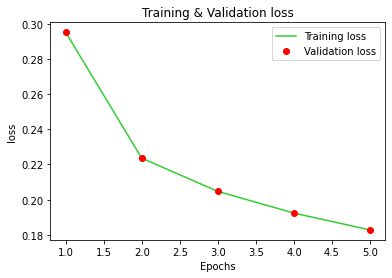

In [23]:
# loss 의 변화 시각화

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss', color='limegreen')
plt.plot(epochs, loss, 'bo', label='Validation loss', color='red')
plt.title('Training & Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

**결과: epoch 가 증가할수록 오버피팅되지 않고 val_loss 가 성공적으로 줄어드는 모습을 보였다.**

### (2) Basic Neural Network Model + Batch Normalization + Max Pooling + Dropout + loss function: categorical crossentropy
- activation function: relu
- optimizer: Adam
- **loss function: categorical_crossentropy**
- batch size: 64
- epoch: 5
- batch normalization
- max pooling
- dropout

In [27]:
# Layer 1
model = Sequential()
model.add(Conv2D(32, (3,3), activation="relu", input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH , IMAGE_CHANNEL)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Layer 2
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Layer 3
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
          
# Fully Connected 
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2,activation="softmax"))

In [28]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_9 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 64)       

In [29]:
history = model.fit_generator(
                    train_generator,
                    epochs = 5,
                    validation_data=(val_generator))

Epoch 1/5
1334/1334 [==============================] - 430s 322ms/step - loss: 0.9343 - accuracy: 0.5899 - val_loss: 0.5858 - val_accuracy: 0.6814
Epoch 2/5
1334/1334 [==============================] - 427s 320ms/step - loss: 0.6200 - accuracy: 0.6699 - val_loss: 0.5630 - val_accuracy: 0.7080
Epoch 3/5
1334/1334 [==============================] - 415s 311ms/step - loss: 0.5968 - accuracy: 0.6880 - val_loss: 0.4824 - val_accuracy: 0.7654
Epoch 4/5
1334/1334 [==============================] - 394s 295ms/step - loss: 0.5597 - accuracy: 0.7118 - val_loss: 0.6346 - val_accuracy: 0.7104
Epoch 5/5
1334/1334 [==============================] - 383s 287ms/step - loss: 0.5268 - accuracy: 0.7395 - val_loss: 0.7088 - val_accuracy: 0.7166


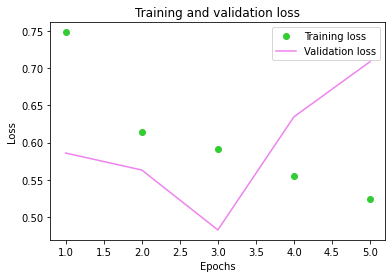

In [30]:
# loss 의 변화 시각화

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss', color='limegreen')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'red')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**결과: categorical_crossentropy loss 함수는 고양이, 강아지 이진분류 문제에 적합하지 않다.**

### (3) Basic Neural Network Model + Batch Normalization + Max Pooling + Dropout + loss function: binary crossentropy
loss 함수에 binary_crossentropy 함수를 사용해본다.
- activation function: relu
- optimizer: Adam
- **loss function: binary_crossentropy**
- batch size: 64
- epoch: 5
- batch normalization
- max pooling
- dropout

In [31]:
# Layer 1
model = Sequential()
model.add(Conv2D(32, (3,3), activation="relu", input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH , IMAGE_CHANNEL)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Layer 2
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Layer 3
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
          
# Fully Connected 
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2,activation="softmax"))

In [32]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 64)       

In [34]:
history = model.fit_generator(
                    train_generator,
                    epochs = 5,
                    validation_data=(val_generator))

Epoch 1/5
1334/1334 [==============================] - 422s 316ms/step - loss: 0.8247 - accuracy: 0.5899 - val_loss: 0.6231 - val_accuracy: 0.6532
Epoch 2/5
1334/1334 [==============================] - 455s 341ms/step - loss: 0.5799 - accuracy: 0.6975 - val_loss: 0.5378 - val_accuracy: 0.7334
Epoch 3/5
1334/1334 [==============================] - 469s 351ms/step - loss: 0.5310 - accuracy: 0.7381 - val_loss: 1.2117 - val_accuracy: 0.6282
Epoch 4/5
1334/1334 [==============================] - 454s 340ms/step - loss: 0.4906 - accuracy: 0.7603 - val_loss: 0.6723 - val_accuracy: 0.7218
Epoch 5/5
1334/1334 [==============================] - 380s 285ms/step - loss: 0.4662 - accuracy: 0.7767 - val_loss: 0.5013 - val_accuracy: 0.7866


In [36]:
# 모델 저장
model.save_weights("model.h5")

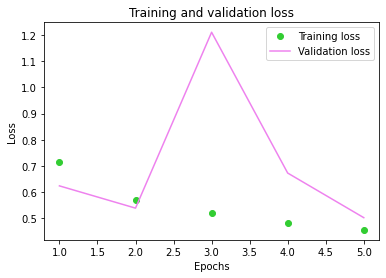

In [38]:
# loss 의 변화 시각화

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss', color='limegreen')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'violet')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**결과: 실험 상 val_accuracy 가 78.66%가 나왔으므로, 해당 모델을 사용해 예측 실험을 해본다.**

## Results with Test Data

In [40]:
# 테스트 데이터 불러오기
filenames = os.listdir(path+"/test1")

test_df=pd.DataFrame( {"filename":filenames} )      
test_df

nbsamples=test_df.shape[0]

In [42]:
test_datagen=ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_dataframe(
    test_df,
    path+"/test1",
    x_col= "filename",
    y_col= None,
    target_size = IMAGE_SIZE,
    class_mode = None,
    batch_size = batch_size,
    shuffle = False)

Found 12500 validated image filenames.


In [44]:
# 테스트 데이터로 예측하기
predict= model.predict_generator(test_generator, 
                                steps=nbsamples/batch_size)
                                
test_df['category']=np.argmax(predict, axis=1)

In [75]:
# 테스트 데이터 샘플 하나로 잘 예측했는지 검사하기
test_df['category']=test_df['category'].replace({0:'cat',1:"dog"})
ex_df=test_df.sample(n=1).reset_index(drop=True)
ex_df

,filename,category
0,4437.jpg,dog


In [80]:
ex_generator = test_datagen.flow_from_dataframe(
                    ex_df,
                    path+"/test1",
                    x_col = "filename",
                    y_col = None,
                    target_size = IMAGE_SIZE,
                    class_mode = None)

Found 1 validated image filenames.


In [81]:
test_sample=list(ex_df.filename)

sample = ""
for test in test_sample:
    sample += test

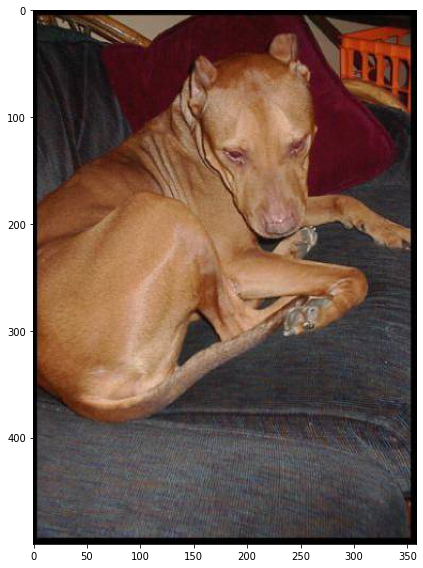

In [82]:
image = image.load_img(path+"/test1/"+sample)
plt.figure(figsize=(8,8))
plt.imshow(image)

plt.tight_layout()
plt.show()

**Test data 로 예측한 결과, 강아지 사진을 dog 카테고리라고 잘 예측하는 것을 볼 수 있다.**